In [10]:
from src import ForecastEmulator
from datetime import datetime, timedelta
import plotly.express as px
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Storage for Home EMS and power smoothing
- Create a generic ESS class for a simple storage model without efficiency
- Create an optimization model that simulate the operation of a home storage to smooth the power at the meter level

In [11]:
from dataclasses import dataclass
@dataclass
class ESS:
    p_max: float = 0.0   # Rated Charge Power
    e_max: float = 0.0    # Rated Energy
    soc_min : float = 0.0 #Minimum state of charge
    soc_max : float = 100.0 #Maximum state of charge
    soc_init: float = 50.0  # Initial State of Charge


In [12]:
import pyomo.environ as pyo

def home_ems(net_load, ESS):

    deltaT=0.25  #1h time step in DA market
    T = len(net_load)

    model = pyo.ConcreteModel()

    # Variables
    model.p = pyo.Var(range(T), within=pyo.Reals, bounds = [-ESS.p_max ,ESS.p_max ])  # charging
    model.pgrid_plus = pyo.Var(range(T), within=pyo.NonNegativeReals, bounds = [0, max(net_load)])  # grid power
    model.pgrid_minus = pyo.Var(range(T), within=pyo.NonNegativeReals, bounds = [0, max(net_load)])  # grid power
    model.soc = pyo.Var(range(T+1), within=pyo.NonNegativeReals, bounds = [ESS.soc_min ,ESS.soc_max ] ) # state of

    # Objective: maximize profit
    model.obj = pyo.Objective(
        expr=sum((model.pgrid_plus[t]**2+model.pgrid_minus[t]**2)*deltaT**2 for t in range(T)),
        sense=pyo.minimize
    )

    # Constraints list
    model.constraints = pyo.ConstraintList()

    # Initial SOC
    model.constraints.add(model.soc[0] == ESS.soc_init)
    #model.constraints.add(model.soc[T] == ESS.soc_init)

    for t in range(T):
            model.constraints.add(
                model.soc[t+1] == model.soc[t]-model.p[t]*deltaT/max(1e-6,ESS.e_max)*100
            )

            model.constraints.add(
                model.pgrid_plus[t]-model.pgrid_minus[t] == net_load[t]-model.p[t]
            )

    solver = pyo.SolverFactory("gurobi")
    solver.solve(model, tee=False)

    pess = np.asarray([pyo.value(model.p[t]) for t in range(T)])
    soc = np.asarray([pyo.value(model.soc[t]) for t in range(T)])

    return pess, soc


# Setup Simulation
- Create an ESS object
- Load consumption and generation profiles + scaling factor
- Set the simulation horizon
- Compute the optimal performances value
- Display time series along the simulated horizon

In [13]:
ess=ESS(p_max = 3, e_max = 10)
pv_max=3
load_max=6
pv = pd.read_excel('../data/pv_uk_norm.xlsx', index_col = 0)
pv = pv['PV1']*pv_max
load = pd.read_excel('../data/load_uk_norm.xlsx', index_col = 0)
load = load['demand_MW']*load_max
net_load = load-pv

In [14]:
#Run optimization along the test period
start_time = datetime(2019,6,1,0,0)
end_time = datetime(2019,6,8,0,0)
net_load_p = net_load.loc[start_time:end_time].iloc[:-1]
pess, soc = home_ems(net_load_p.values,ess)
net_load_opt_p = net_load_p-pess

In [15]:
#Compute performances metrics
P2_wo_opt = sum(net_load_p**2*0.25**2)
P2_w_opt = sum(net_load_opt_p**2*0.25**2)
print(f' Performances without optimization P2 (kWh²) = {P2_wo_opt:.2f}')
print(f' Optimal performances  P2 (kWh²)  = {P2_w_opt:.2f}')


 Performances without optimization P2 (kWh²) = 90.65
 Optimal performances  P2 (kWh²)  = 56.40


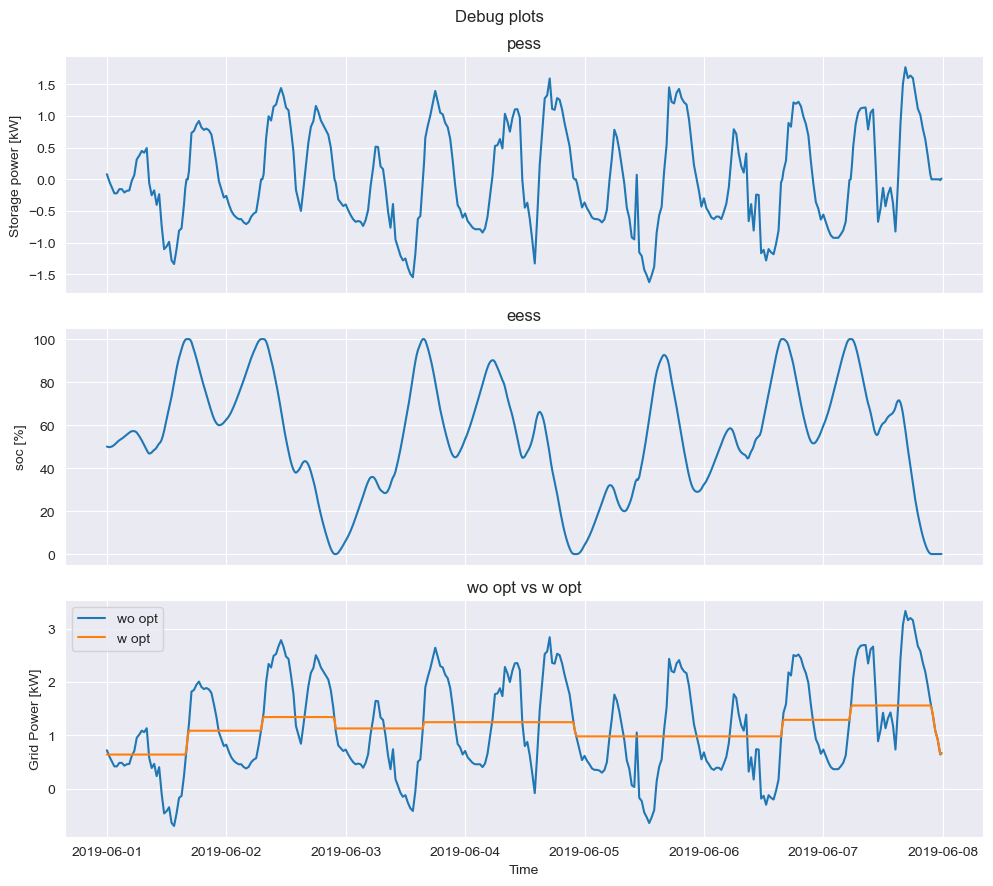

In [16]:
#Plot time series results
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
axs[0].plot(net_load_p.index, pess, label="pess")
axs[0].set_title("pess")
axs[0].set_ylabel("Storage power [kW]")
axs[1].plot(net_load_p.index, soc, label="soc")
axs[1].set_title("eess")
axs[1].set_ylabel("soc [%]")
axs[2].plot(net_load_p.index, net_load_p.values, label="wo opt")
axs[2].plot(net_load_p.index, net_load_opt_p.values, label="w opt")
axs[2].set_title("wo opt vs w opt")
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Grid Power [kW]")
axs[2].legend()
fig.suptitle("Debug plots")
plt.tight_layout()
plt.show()

# Run Test Simulations
- Generate a forecast emulator based on prices profiles
- Loop over different error values with several runs
- Store and display the results

In [20]:
from tqdm import tqdm

# Generate Simulation parameters
error_list= [10, 20] # np.linspace(5,50,10)
forecast_update_list = [60*4, 60*24] #[60*i for i in [2,4,8,24] ]
forecast_horizon=24*60
nb_runs = 2
total = len(error_list)*nb_runs*len(forecast_update_list)

# Initialize dictionnaries containing results
results_ts = {}
results_P2 = []

#Intialize forecast emulator
emulator = ForecastEmulator(ts_in = net_load,
                            nb_states = 30,
                            nb_forecast_profiles =300)


In [21]:
#Run Simulations
with tqdm(total = total) as pbar:
    for forecast_update in forecast_update_list:
        for forecast_error in error_list:
            for run in range(nb_runs):

                #Reinitialize start time for every indepednant simulations
                start_time_t=start_time

                # Initialize an empty df for ess profiles
                ess.soc_init = 50
                df_ess=pd.DataFrame(columns=['pess', 'soc', 'p_sim'], index = net_load_p.index)

                while start_time_t < end_time :

                    # Define the time slice
                    time_slice = slice(start_time_t, start_time_t + timedelta(minutes=forecast_horizon-15))
                    idx = df_ess.loc[time_slice].index
                    n = len(idx)  # number of time steps available

                    # Get net load values for the time window
                    net_load_t = net_load.loc[time_slice]

                    # Optimal daily profit
                    reference, net_load_t = emulator.forecast(start_time = start_time_t,
                                                         duration_minutes  = forecast_horizon,
                                                         target_error = forecast_error,
                                                         metric = 'nrmse',
                                                         selection = 'closest')

                    # Run your EMS function
                    pess, soc = home_ems(net_load_t.values, ess)

                    # Assign results back to the DataFrame safely
                    df_ess.loc[time_slice, 'pess'] = pess[:n]
                    df_ess.loc[time_slice, 'soc'] = soc[:n]

                    #Increment time
                    start_time_t = start_time_t + timedelta(minutes = forecast_update)

                    if forecast_update > forecast_horizon :
                        raise ValueError("Forecast update cannot be longer that Forecast Horizon")
                    else :
                        if start_time_t < end_time and forecast_update < forecast_horizon:
                            ess.soc_init=df_ess.loc[start_time_t]['soc']
                        elif start_time_t < end_time and forecast_update == forecast_horizon:
                            ess.soc_init=soc[-1]-pess[-1]*0.25/ess.e_max*100

                # Compute objective
                df_res =   pd.DataFrame({
                                'pess': np.array(df_ess['pess'], dtype=float),
                                'soc': np.array(df_ess['soc'], dtype=float),
                                'p_sim': np.array(net_load_p - df_ess['pess'], dtype=float)
                            },index=net_load_p.index)

                P2_sim = sum(df_res['p_sim'].values**2*0.25**2)

                results_ts[(forecast_update, forecast_error, run)]=df_res
                results_P2.append({'forecast_error' : forecast_error,
                                  'forecast_update' : forecast_update,
                                  'run': run,
                                  'precision' : 100.0-(P2_sim-P2_w_opt)/(P2_wo_opt-P2_w_opt)*100.0})
                pbar.update(1)

results_P2=pd.DataFrame(results_P2)

100%|██████████| 8/8 [01:37<00:00, 12.14s/it]


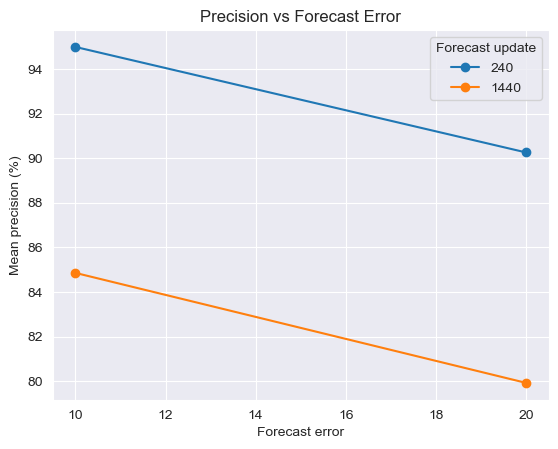

In [22]:
#Plot the EMS precision
df_mean = results_P2.groupby(["forecast_error", "forecast_update"])["precision"].mean().reset_index()
df_plot = df_mean.pivot(
    index="forecast_error",
    columns="forecast_update",
    values="precision"
)
df_plot.plot(marker="o")
plt.xlabel("Forecast error")
plt.ylabel("Mean precision (%)")
plt.title("Precision vs Forecast Error")
plt.legend(title="Forecast update")
plt.show()

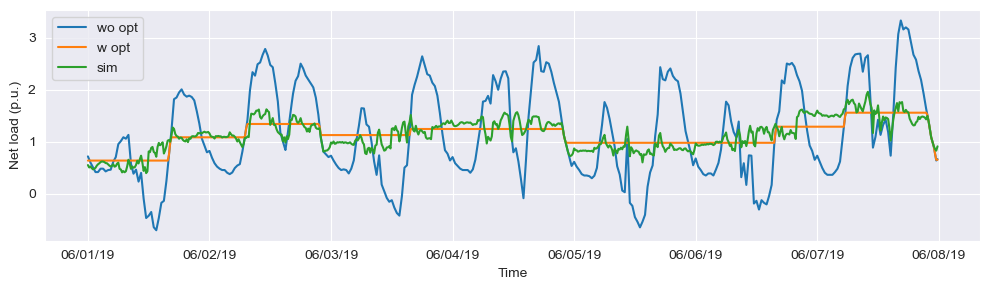

In [29]:
#Display the time series results for a given simulation
forecast_update = 4*60
forecast_error = 10
run = 2
df_res=results_ts[(forecast_update, forecast_error, run-1)]

import matplotlib.dates as mdates
plt.figure(figsize=(10, 3))  # set figure size here
plt.plot(net_load_p.index, net_load_p.values, label="wo opt")
plt.plot(net_load_p.index, net_load_opt_p.values, label="w opt")
plt.plot(net_load_p.index, df_res['p_sim'].values, label="sim")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%D"))
plt.xlabel("Time")
plt.ylabel("Net load (p.u.)")
plt.legend()
plt.tight_layout()
plt.show()